<a href="https://colab.research.google.com/github/retospect/PCR-Template-Generator/blob/main/PCR_Template_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generating sequences that are primer ready

This code generates a DNA template with good settings for primers and qPCR probes according to guidelines.

The latest version lives at https://github.com/retospect/PCR-Template-Generator

## Overall methodology
It generates an initial random sequence, then performs simplified simulated annealing to modify it so that it satisfies all the desired requirements:
1. *Calculate cost*: add up penalty points for everything that's wrong with this sequence, for example a lack of GC clamp, or patterns that will lead to primer dimer.
2. *Mutate sequence*: change some basepairs at random.
3. *Compare*: Check the original sequence against the mutated sequence, and keep the better one. 
4. *Repeat until happy*: Keep on repeating these steps until an OK solution presents itself or we run out of patience. 

## Overall structure
The overall structure here is approximately like this:

    123456789 123456789 12   123456789 123456789 12345
    Forward-primer---CLAMP   -----probe---------------
    123456789 123456789 123456789 123456789 123456789 123456789 123456789 12345
                                                         CLAMP---Reverse-primer
                                                         21 987654321 987654321
Search for rules.append below to see the exact rules that are enforced. 

They include:
* Overall
  * No runs of same bases longer than 3
  * Overall GC content ~50%
  * The last 4 bases on any 3' end are unique to avoid primer dimer
  * Templates don't end with G or C on the 3' ends
  * No self-annealing structures longer than 5bp to keeps ΔG for hairpins positive (hairpins)

* Primers
  * GC content ~50%
  * GC clamp on 3' end (3 of 5 bases are G or C)
  * Ends with G or C on 3' end
  * Melting temperature within 1°C of each other
  * 2 AT bases right next to the primer so that other tools identify primers

* Probe
  * Melting temperature ~8°C higher than primers
  * Probe does not have a G on 5'end

## Debugging
The Rules class exists for debugging convenience - it allows the developer to see which rules cause ongoing troubles and keep the sequence from fitting all the criteria.

A debug flag provides verbose output on rule failures and steps.  


## Getting started
To execute code in the Jupyter notebook, hit Shift-Enter in a code cell. Do this in the next few cells to get some output.

## Where to run
This notebook can run on Google's cloud at http://colab.research.google.com, or on your laptop using a custom Jupyter install. We've tested it there. 

In [3]:
# COLAB Setup
# Installing the biopython libraries in this runtime environment
# This works if you run this Jupyter notebook on the free hosted colab.research.google.com
!pip3 install biopython==1.78

# The next two lines fix the error "No module named 'Bio'" for BioPython imports 
# that occurs with an Anaconda Navigator installation on OSX
# It's fixed by making python imports case insensitive
import os
os.environ['PYTHONCASEOK'] = '1'

import Bio
print("Library available, all's well")

     |████████████████████████████████| 2.3MB 2.8MB/s 
Library available, all's well


In [5]:
# The next two lines fix the error "No module named 'Bio'" for BioPython imports 
# that occurs with an Anaconda Navigator installation on OSX
# It's fixed by making python imports case insensitive
import os
os.environ['PYTHONCASEOK'] = '1'

# Continue with imports normally.
from Bio.Seq import Seq
from Bio.SeqUtils import GC
from Bio.SeqUtils import MeltingTemp
import math
import numpy as np
import random

bases = ['a','t','g','c']

# Cost rules
class Rule:
  """Base rule class"""
  def __init__(self, name="BaseRule", sequence="", note=""):
    self._name = name
    self._note = note
    self._cost = 0
  
  def getName(self):
    return self._name

  def getNote(self):
    return self._note
 
  def getCost(self):
    return self._cost

class gcContent(Rule):
  """GC Content rule: GC Content should be within a range"""
  def __init__(self, name="gcContent", min=45, max=55, sequence="", note=""):
    super().__init__(name=name, sequence=sequence, note=note)
    gc_content = GC(sequence)
    if gc_content < min or gc_content > max:
      self._cost = abs(gc_content - (np.average([min, max])))
      self._note += " GC_Content: "+str(gc_content)

class LongRuns(Rule):
  """Repeats of identical bases should not be longer than some length"""
  def __init__(self, name="Repeats", maxLen=3, sequence="", note=""):
    super().__init__(name=name, sequence=sequence, note=note)
    for base in bases:
      if -1 != sequence.find(base * (maxLen+1)):
        self._cost += maxLen

class MeltingRange(Rule):
  """Sequence should melt in temperature range"""
  def __init__(self,name="Melting",  min=45, max=55, sequence="", note=""):
    super().__init__(name=name, sequence=sequence, note=note)
    melting = MeltingTemp.Tm_NN(sequence)
    if melting < min or melting > max:
      self._cost = abs(melting - (np.average([min, max])))

class SingleMatchOnly(Rule):
  """Sequence match exactly once"""
  def __init__(self, name="SingleMatch", sequence="", pattern="", note=""):
    super().__init__(name=name, sequence=sequence, note=note)
    if sequence.count_overlap(pattern) > 1:
        self._cost = 2

class SecondaryLimit(Rule):
  """Sequence should not have secondary structures longer than maxLen"""
  def __init__(self, name="Secondary", sequence="", maxLen=10, note=""):
    super().__init__(name=name, sequence=sequence, note=note)
    for i in range(len(sequence)-maxLen):
      substr = sequence[i:i+maxLen]
      if sequence.find(substr.complement()) > 1:
        self._cost += 1
      if sequence.find(substr.reverse_complement()) > 1:
        self._cost += 1


class Sequence:
  # Constructor with default parameters
  def __init__(self, seq_length = 75, primer_length = 22, probe_length=25, primer_melt=53, 
               probe_gap=3, sequence = "", debug=False):
    self._primer_length = primer_length
    self._probe_length = probe_length
    self._seq_length = seq_length
    self._primer_melt = primer_melt
    self._probe_gap = probe_gap # Gap between probe and 3' end of reverse primer
    self._cost_comment = ""
    self._debug = debug
    self._rules = []
    if sequence is "":
      sequence = "".join([random.choice('atgc') for x in range(seq_length)])
    self._sequence = Seq(sequence)

  def setSequence(self, newSequence):
    self._sequence = Seq(str(newSequence))

  def fwd(self):
    """Forward sequence 5'-3'"""
    return self._sequence

  def rev(self):
    """Reverse sequence 5'-3'"""
    return self._sequence.reverse_complement()

  def fwd_primer(self):
    """Forward primer 5'-3' """
    return self._sequence[:self._primer_length]

  def probe(self):
    """Returns the probe"""
    probe_start = self._seq_length - self._primer_length - self._probe_length - 3
    probe_end = self._seq_length - self._primer_length - self._probe_gap
    return self._sequence[probe_start:probe_end]


  def rev_primer(self):
    """Reverese primer 5'-3'"""
    return self._sequence[-self._primer_length:].reverse_complement()

  def three_prime_ends(self, end_length = 4):
    """Returns all the 3' ends of the sequences and primers"""
    return [self.fwd()[-end_length:], self.rev()[-end_length:],
           self.fwd_primer()[-end_length:], self.rev_primer()[-end_length:] ]

  def mutate(self, how_many=3):
    """Replaces how_many base pairs in this sequence with random basepair. 25% chance base does not change"""
    for index in random.sample(range(0, len(self._sequence)), how_many):
      self._sequence = self._sequence[:index] + random.choice(bases) + self._sequence[index+1:]

  def cost_message(self):
    """String that describes the cost contributors from the last run"""
    return self._cost_comment

  def display(self):
    """Multi-line string that shows primers and template, forward and reverse"""
    template_spacing = self._seq_length - 2*self._primer_length - self._probe_length - self._probe_gap
    return self.fwd_primer() + (" "*template_spacing) + self.probe() +\
      "\n" + self.fwd() + \
      "\n" + self.fwd().complement() + \
      "\n" + (" " * (self._seq_length - self._primer_length)) + \
      self.rev_primer()[::-1]

  def rule_info(self, verbose=False):
    msg = ""
    for rule in self._rules:
      if rule.getCost() > 0 or verbose:
        msg += str(rule.getCost()) + " "
        msg += rule.getName() + " "
        msg += rule.getNote() + "\n"
    return msg

  def cost(self):
    rules = []

    probe_length = self._probe_length
    primer_length = self._primer_length

    rules.append(
        LongRuns(sequence=self.fwd(), maxLen=3, note="No runs longer than 3"))
    rules.append(
        gcContent(sequence=self.fwd(), min=49, max=51, note="Overall"))

    # Checking both the primers
    for primer in self.fwd_primer(), self.rev_primer():
      rules.append(gcContent(sequence=primer, min=49, max=51, note="Primer"))
      
      # Primers should melt within +-1C of target temperature, 53°C 
      # 53C is about the mean for 50% GC content as determined below
      primer_temp = 53
      rules.append(MeltingRange(sequence=primer, min=primer_temp-1, max=primer_temp+1, note="Primer"))

      # # Penalty if the GC content is not 50% in the last n bases on the 3' end.
      for clamp_length in [5,11]:
          rules.append(gcContent(sequence=primer[-clamp_length:], min=55, max=79, note="GC Clamp"))

      # and the last base at the 3' end of the primer should be a G or a C
      rules.append(gcContent(sequence=primer[-1:], min=99, max=101, note="3' primer end"))

    # All 3 prime ends (primers and forward and backward strands)
    # should only bind once. 
    # the full seqence, both forward and reverse combined, in 5' to 3' order
    full_length = self.fwd() + self.rev()

    # We check the 3' ends. Each one should exist exactly once in this combined
    # sequence to avoid primer dimers by making it near impossible for 3' ends
    # to bind to the sequence anywhere.

    # number of unique bases at 3' end of probes, templates, primers
    # Making this 3 is overly restrictive and causes compute times to spike, 
    # but 4 should still melt even in worst case
    unique_tp_end = 4 

    for the_end in self.three_prime_ends(unique_tp_end), :
      rules.append(SingleMatchOnly(sequence=full_length, pattern=the_end, note="Unique 3' ends"))

    # Penalty for 3' ends of template if they end with a G or a C
    # It's cheap and likely reduces primer dimers.
    # for both the forward and the reverse of the template
    for template in [self.fwd(), self.rev()]:
      rules.append(gcContent(sequence=template[-1:], min=-1, max=1, note="3' template ends"))

      # To force other tools to put the primers in the right spot, we 
      # make sure the 2 bases after the primers are not GC
      rules.append(gcContent(sequence=template[self._primer_length:self._primer_length+2], min=-1, max=1, note="Primer Forcing"))
    
    # Probe should be close to the reverse primer (offset specifies how far)
    # Its melting temperature should be about 8°C higher than the primers
    # https://www.idtdna.com/pages/education/decoded/article/designing-pcr-primers-and-probes
    offset = self._probe_gap
    probe = self.fwd()[-(probe_length+primer_length+offset):-(primer_length+offset)]
    rules.append(MeltingRange(sequence=probe, min=primer_temp+8, max=primer_temp+10))
    rules.append(gcContent(sequence=probe, min=48, max=52))
    rules.append(SingleMatchOnly(sequence=full_length, pattern=probe[-unique_tp_end:]))
    rules.append(gcContent(sequence=probe[:1], min=-1, max=1)) # 5' end of probe is not a G!

    # Penalty for secondary structures that are longer than 5 bases anywhere
    # This reduces the likelyhood of secondary structures a lot
    # Observed ΔG appears to be always positive if maxLen = 4;
    rules.append(SecondaryLimit(sequence=self.fwd(), maxLen=4))

    self._rules = rules

    cost = 0
    for rule in rules:
      cost += rule.getCost()

    return cost

def runExperiment(debug = False):
  bestSequence = Sequence()
  bestCost = bestSequence.cost()

  mutantSequence = Sequence(debug=debug)
  i = 0
  time_since_improvement = 0

  # Randomly change the sequence and keep improvements until cost is less than 1
  while bestCost > 1:
    mutantSequence.setSequence(bestSequence.fwd())
    # Change between 1 and 5 random bases at once
    mutantSequence.mutate(how_many=random.randint(1, 8))
    mutantCost = mutantSequence.cost();
    if mutantCost < bestCost:
      bestSequence.setSequence(mutantSequence.fwd())
      bestCost = mutantCost
      time_since_improvement = 0
      if debug:
        print("Reduced cost to {:6.2f} at cycle {:5d} with {}".format(bestCost, i, mutantSequence.cost_message()))
        print(mutantSequence.rule_info())
    i += 1
    time_since_improvement += 1
    # This should take no more than many mutations.
    # If it takes longer, something is likely wrong, maybe we ask for
    # a mutually exclusive set of requirements
    if i > 1e5:
      if debug:
        print("\n\nFAILURE TO DISCOVER\n\n")
      return 0;
  
  return bestSequence

exp = runExperiment(debug=True)
if exp != 0:
  print(exp.display())

Reduced cost to 403.54 at cycle     1 with 
7.333333333333336 gcContent Overall GC_Content: 42.666666666666664
9.090909090909093 gcContent Primer GC_Content: 40.90909090909091
1.2750611393235545 Melting Primer
12.454545454545453 gcContent GC Clamp GC_Content: 54.54545454545455
9.090909090909093 gcContent Primer GC_Content: 59.09090909090909
6.802434366242608 Melting Primer
27.0 gcContent GC Clamp GC_Content: 40.0
100.0 gcContent 3' primer end GC_Content: 0.0
100.0 gcContent 3' template ends GC_Content: 100.0
50.0 gcContent Primer Forcing GC_Content: 50.0
11.497188754632873 Melting 
18.0 gcContent  GC_Content: 32.0
2 SingleMatch 
49 Secondary 

Reduced cost to 388.98 at cycle     4 with 
4.666666666666664 gcContent Overall GC_Content: 45.333333333333336
3.470920137577707 Melting Primer
12.454545454545453 gcContent GC Clamp GC_Content: 54.54545454545455
9.090909090909093 gcContent Primer GC_Content: 59.09090909090909
6.802434366242608 Melting Primer
27.0 gcContent GC Clamp GC_Content: 40

In [6]:
# This code block generates 10 solutions with the mechanism above
generated = 0
while generated < 10:
  s = runExperiment()
  if s != 0:
    print(s.display())
    print("\n")
    generated +=1


actagaaagagaccagcctgag   atgagccgaaagcaacgcgacgata
actagaaagagaccagcctgagtagatgagccgaaagcaacgcgacgatacaactagcccacctagattggcata
tgatctttctctggtcggactcatctactcggctttcgttgcgctgctatgttgatcgggtggatctaaccgtat
                                                     gatcgggtggatctaaccgtat


ataagctgtaggtcctgtcacg   ttgtttgtggcgttgccgattggtg
ataagctgtaggtcctgtcacgatgttgtttgtggcgttgccgattggtggttctgagccctgtagttcctgtat
tattcgacatccaggacagtgctacaacaaacaccgcaacggctaaccaccaagactcgggacatcaaggacata
                                                     gactcgggacatcaaggacata


atacgggataaacacgggagtc   aagcaacgcagcagcacatgatgac
atacgggataaacacgggagtcttgaagcaacgcagcagcacatgatgacgaaggagagcaacctgagagattga
tatgccctatttgtgccctcagaacttcgttgcgtcgtcgtgtactactgcttcctctcgttggactctctaact
                                                     cctctcgttggactctctaact


tagttccttgtagggacggtag   acgcacacgacagggacagttgttt
tagttccttgtagggacggtagttcacgcacacgacagggacagttgtttgatgggtagttcgccttattcggta
atcaaggaacatccctgccatcaagtgcgt

## Determine melting point of 21 bases with 50% GC

Here we create 10000 random sequences and plot GC vs melting point. 

It appears that a target temperature of 53°C is about equivalent of a 50% GC content when using the Tm_NN method. 
https://biopython.org/docs/1.75/api/Bio.SeqUtils.MeltingTemp.html

Other tools like http://idtdna.com and SnapGene viewer use different algorithms, but the temperatures are usually in proportion - so if two equal lenght primers are melting within 1°C here, they are melting within 1°C there, as well. If one melts 10°C higher here, same there.

Temperature	53.31°C mean,	53.31°C average
GC content 	50.02% mean,	50.02% average


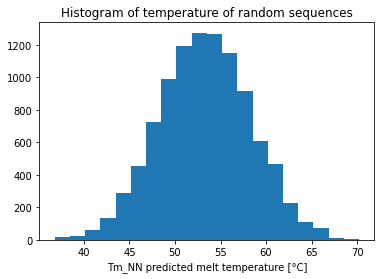

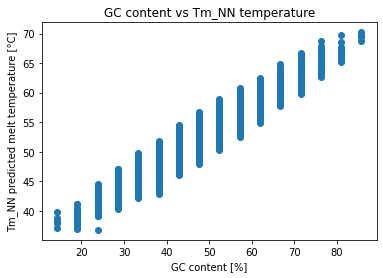

In [7]:
import random
from Bio.SeqUtils import MeltingTemp
import matplotlib.pyplot as plt
import numpy as np

seq_length = 21
samples = 10000
temperature = np.zeros(samples)
gc = np.zeros(samples)
for i in range(samples):
  s = "".join([random.choice('atgc') for x in range(seq_length)])
  t = MeltingTemp.Tm_NN(s)
  temperature[i] = t
  gc[i] = GC(s)

print("Temperature\t{:4.2f}°C mean,\t{:4.2f}°C average".format(temperature.mean(), np.average(temperature)))
print("GC content \t{:4.2f}% mean,\t{:4.2f}% average".format(gc.mean(), np.average(gc)))
n, bins, patches = plt.hist(temperature, bins=20)
plt.title("Histogram of temperature of random sequences")
plt.xlabel("Tm_NN predicted melt temperature [°C]")
plt.figure()
plt.scatter(gc, temperature)
plt.title("GC content vs Tm_NN temperature")
plt.xlabel("GC content [%]")
plt.ylabel("Tm_NN predicted melt temperature [°C]");